In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#Global Parameters and Variables loaded 
import config

In [2]:
# load dataloader
if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

In [3]:
#empty cuda cache
torch.cuda.empty_cache()

## Models


In [4]:
print(config.channels)

class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()
        self.resnet50 = models.resnet50()
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)
    



class ResNet101_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_Classifier, self).__init__()
        self.resnet101 = models.resnet101()
        
        # Modify the first convolutional layer
        self.resnet101.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet101.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet101(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

    
class ModifiedResnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResnet50_Classifier, self).__init__()
        
        # Load the pretrained ResNet-50 model
        #self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50 = models.resnet50()
        # Modify the first convolutional layer
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet50.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3


## Train Test and Val split

In [5]:
#------Datasplit
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
#train_df, test_df = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
#val_df = test_df
random_state = 7
train_df, temp = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=random_state)
test_df, val_df = train_test_split(temp, test_size=0.5, stratify=temp['Label_int'], random_state=random_state)
# train test split
print("Train size: ", len(train_df))
print("Test size: ", len(test_df))
print("Val size: ", len(val_df))



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64


## Model initialization

In [6]:

#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  
#model = Resnet50_Classifier(num_classes)
model = ModifiedResnet50_Classifier(num_classes)
#model = ResNet101_Classifier(num_classes)

# Hyperparameters
num_epochs = config.finetune_epochs 
learning_rate = 0.0003
weight_decay = 0  # L2 regularization
batch_size = config.batch_size
patience = config.patience

#  Transfer the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) # Adjust the value as needed)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.6, verbose=True)

#new folder path
standalone_results_path = f'./results_standalone/SA_ADSMI_{num_epochs}_epochs_{datetime.datetime.now().strftime("%Y-%m-%d-%H")}'

# Create a directory to save the results
if not os.path.exists(standalone_results_path):
    os.makedirs(standalone_results_path)

with open(f'{standalone_results_path}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'training on {data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')

train_losses = []
val_losses = []
best_accuracy = 0
best_loss = 1000
early_stop_counter = 0
#config.model_path = "./results_standalone/newgpu2_checkpoint.pth"


In [7]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy and loss
    accuracy = correct_predictions / total_samples
    if correct_predictions / total_samples > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, standalone_results_path + '/checkpoint.pth')
        early_stop_counter = 0
        with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model, standalone_results_path + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")
    with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
# Save full model
torch.save(model, standalone_results_path + '/Full_model_checkpoint.pth')

100%|██████████| 118/118 [00:32<00:00,  3.61it/s]


Epoch [1/120], Train Loss: 0.9234, Val Loss: 0.8374, Val Accuracy: 69.28%


100%|██████████| 118/118 [00:31<00:00,  3.72it/s]


Epoch [2/120], Train Loss: 0.7145, Val Loss: 0.5712, Val Accuracy: 75.64%


100%|██████████| 118/118 [00:31<00:00,  3.73it/s]


Epoch [3/120], Train Loss: 0.6071, Val Loss: 0.5158, Val Accuracy: 82.20%


100%|██████████| 118/118 [00:31<00:00,  3.75it/s]


Epoch [4/120], Train Loss: 0.4813, Val Loss: 0.3735, Val Accuracy: 86.23%


100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Epoch [5/120], Train Loss: 0.4416, Val Loss: 0.3754, Val Accuracy: 87.08%


100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Epoch [6/120], Train Loss: 0.4173, Val Loss: 0.4075, Val Accuracy: 85.59%


100%|██████████| 118/118 [00:31<00:00,  3.74it/s]


Epoch [7/120], Train Loss: 0.4026, Val Loss: 0.3110, Val Accuracy: 88.98%


100%|██████████| 118/118 [00:31<00:00,  3.80it/s]


Epoch [8/120], Train Loss: 0.3696, Val Loss: 0.3678, Val Accuracy: 86.02%


100%|██████████| 118/118 [00:31<00:00,  3.80it/s]


Epoch [9/120], Train Loss: 0.3389, Val Loss: 0.2838, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Epoch [10/120], Train Loss: 0.3607, Val Loss: 0.4518, Val Accuracy: 88.14%


100%|██████████| 118/118 [00:31<00:00,  3.80it/s]


Epoch [11/120], Train Loss: 0.3393, Val Loss: 0.3288, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:31<00:00,  3.71it/s]


Epoch [12/120], Train Loss: 0.3358, Val Loss: 0.3377, Val Accuracy: 88.98%


100%|██████████| 118/118 [00:33<00:00,  3.56it/s]


Epoch [13/120], Train Loss: 0.3326, Val Loss: 0.2881, Val Accuracy: 88.56%


100%|██████████| 118/118 [00:33<00:00,  3.55it/s]


Epoch [14/120], Train Loss: 0.3243, Val Loss: 0.4016, Val Accuracy: 85.59%


100%|██████████| 118/118 [00:27<00:00,  4.27it/s]


Epoch [15/120], Train Loss: 0.3183, Val Loss: 0.2908, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Epoch 00016: reducing learning rate of group 0 to 1.8000e-04.
Epoch [16/120], Train Loss: 0.3023, Val Loss: 0.3265, Val Accuracy: 88.35%


100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Epoch [17/120], Train Loss: 0.2823, Val Loss: 0.2717, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:26<00:00,  4.39it/s]


Epoch [18/120], Train Loss: 0.2560, Val Loss: 0.3496, Val Accuracy: 87.50%


100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Epoch [19/120], Train Loss: 0.2666, Val Loss: 0.2671, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:26<00:00,  4.42it/s]


Epoch [20/120], Train Loss: 0.2573, Val Loss: 0.2465, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Epoch [21/120], Train Loss: 0.2648, Val Loss: 0.2771, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Epoch [22/120], Train Loss: 0.2851, Val Loss: 0.3193, Val Accuracy: 88.77%


100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Epoch [23/120], Train Loss: 0.2487, Val Loss: 0.2366, Val Accuracy: 91.74%


100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Epoch [24/120], Train Loss: 0.2419, Val Loss: 0.3107, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Epoch [25/120], Train Loss: 0.2420, Val Loss: 0.2504, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Epoch [26/120], Train Loss: 0.2532, Val Loss: 0.3256, Val Accuracy: 87.50%


100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Epoch [27/120], Train Loss: 0.2549, Val Loss: 0.2543, Val Accuracy: 91.95%


100%|██████████| 118/118 [00:26<00:00,  4.39it/s]


Epoch [28/120], Train Loss: 0.2331, Val Loss: 0.2640, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Epoch [29/120], Train Loss: 0.2478, Val Loss: 0.2886, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch 00030: reducing learning rate of group 0 to 1.0800e-04.
Epoch [30/120], Train Loss: 0.2275, Val Loss: 0.2854, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Epoch [31/120], Train Loss: 0.2221, Val Loss: 0.2884, Val Accuracy: 92.37%


100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Epoch [32/120], Train Loss: 0.2138, Val Loss: 0.2855, Val Accuracy: 90.89%


100%|██████████| 118/118 [00:26<00:00,  4.44it/s]


Epoch [33/120], Train Loss: 0.2138, Val Loss: 0.2426, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Epoch [34/120], Train Loss: 0.1892, Val Loss: 0.2808, Val Accuracy: 92.80%


100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Epoch [35/120], Train Loss: 0.1887, Val Loss: 0.2757, Val Accuracy: 92.58%


100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Epoch [36/120], Train Loss: 0.1893, Val Loss: 0.2573, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:26<00:00,  4.42it/s]


Epoch 00037: reducing learning rate of group 0 to 6.4800e-05.
Epoch [37/120], Train Loss: 0.1986, Val Loss: 0.2850, Val Accuracy: 89.19%


100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Epoch [38/120], Train Loss: 0.1875, Val Loss: 0.2665, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [39/120], Train Loss: 0.1734, Val Loss: 0.3242, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Epoch [40/120], Train Loss: 0.1764, Val Loss: 0.2602, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Epoch [41/120], Train Loss: 0.1660, Val Loss: 0.2766, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Epoch [42/120], Train Loss: 0.1606, Val Loss: 0.2595, Val Accuracy: 91.53%


100%|██████████| 118/118 [00:25<00:00,  4.54it/s]


Epoch [43/120], Train Loss: 0.1653, Val Loss: 0.2691, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Epoch 00044: reducing learning rate of group 0 to 3.8880e-05.
Epoch [44/120], Train Loss: 0.1595, Val Loss: 0.3038, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Epoch [45/120], Train Loss: 0.1468, Val Loss: 0.2813, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Epoch [46/120], Train Loss: 0.1452, Val Loss: 0.3100, Val Accuracy: 91.74%


100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Epoch [47/120], Train Loss: 0.1450, Val Loss: 0.2972, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Epoch [48/120], Train Loss: 0.1376, Val Loss: 0.3251, Val Accuracy: 90.47%
Early stopping on epoch 48


In [8]:
# Save full model
torch.save(model, standalone_results_path + '/Full_model_checkpoint.pth')

## Losses Plot

Tend way more to overfitting than the pretraineds Models also with regularization with masking 

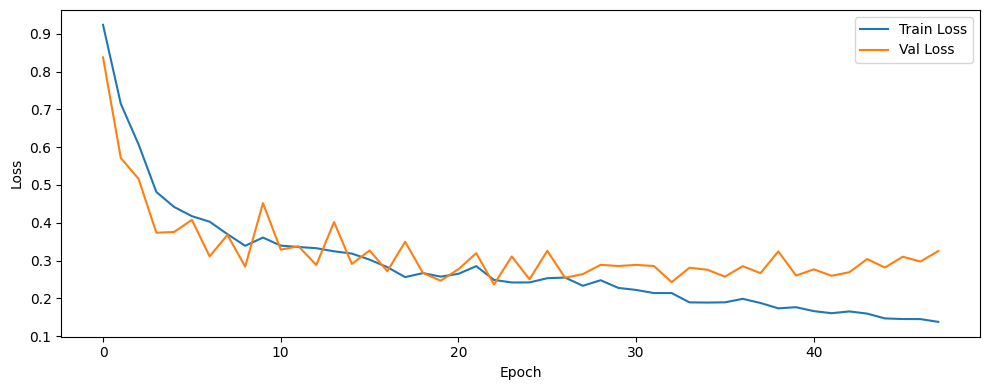

In [9]:
# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(10, 4))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
### Save Results of all 3 Modell Saves: Best-Val-Accuracy, Best-Val-loss and full model


Evaluation Results:
Balanced Accuracy2: 88.46%
Test Accuracy: 92.16%

Evaluation Results:
Accuracy: 92.16%
Precision: 92.44%
Recall: 92.16%
F1-score: 92.16%
Kappa: 87.56%
                         precision    recall  f1-score   support

            [Kreischen]       0.90      0.96      0.93       220
[Kreischen][Quietschen]       0.88      0.90      0.89        71
              [Negativ]       0.98      0.89      0.93       167
           [Quietschen]       0.92      0.79      0.85        14

               accuracy                           0.92       472
              macro avg       0.92      0.88      0.90       472
           weighted avg       0.92      0.92      0.92       472



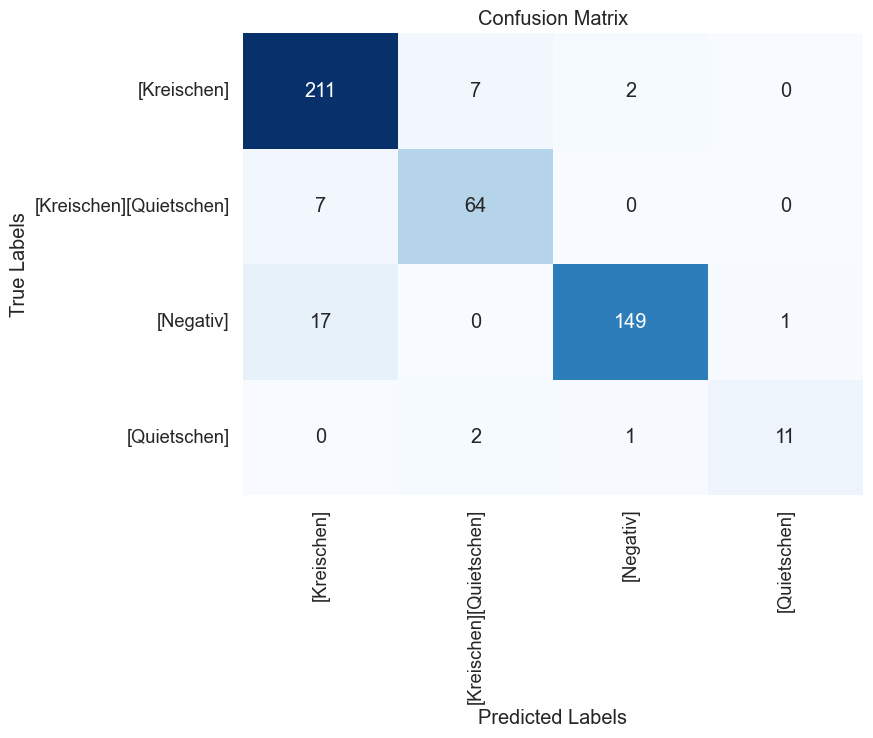

In [11]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.val_sound_length = 20
# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/Full_model_checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_full.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_full.png')










Evaluation Results:
Balanced Accuracy2: 91.14%
Test Accuracy: 93.64%

Evaluation Results:
Accuracy: 93.64%
Precision: 93.76%
Recall: 93.64%
F1-score: 93.66%
Kappa: 89.94%
                         precision    recall  f1-score   support

            [Kreischen]       0.92      0.96      0.94       220
[Kreischen][Quietschen]       0.89      0.90      0.90        71
              [Negativ]       0.98      0.93      0.95       167
           [Quietschen]       0.92      0.86      0.89        14

               accuracy                           0.94       472
              macro avg       0.93      0.91      0.92       472
           weighted avg       0.94      0.94      0.94       472



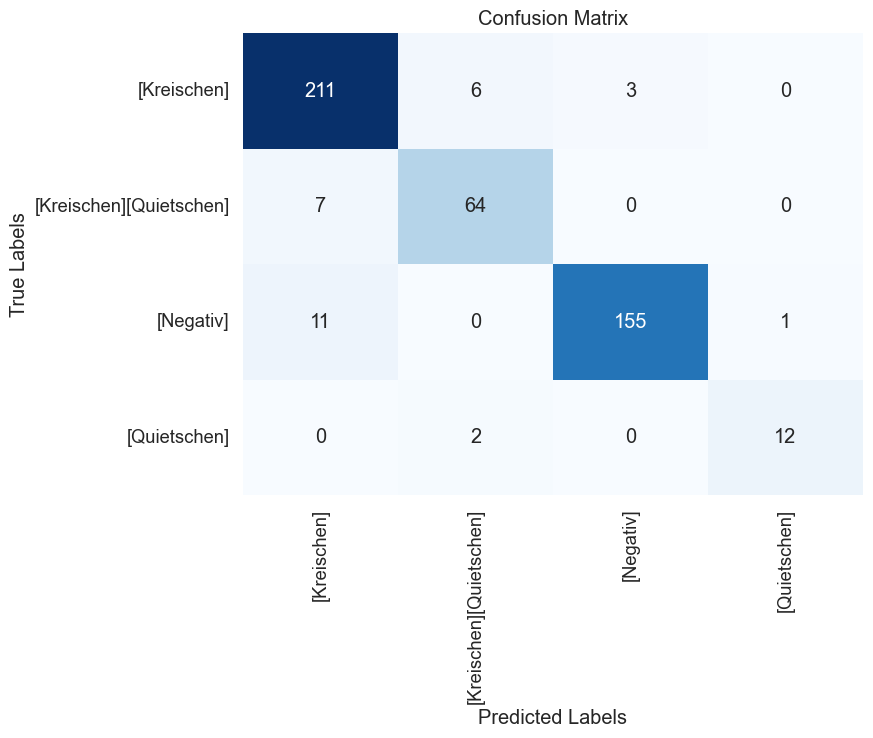

In [12]:

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
#use sklearn  accuracy 
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_best.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plotas a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_best.png')









In [1]:

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/checkpoint_best_loss.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
#use sklearn  accuracy 
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_best_loss.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plotas a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_best_loss.png')









NameError: name 'DL' is not defined

: 